In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.models import load_model
from barazmoon.twitter import twitter_workload_generator
from statsmodels.tsa.arima.model import ARIMA


# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FIGURES_PATH, LSTM_PATH

plt.rc("font", size=16)
plt.rc("axes", titlesize=16)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42


lstm_plot_kwargs = {
    "label": "LSTM",
}
arima_plot_kwargs = {
    "label": "ARIMA",
}

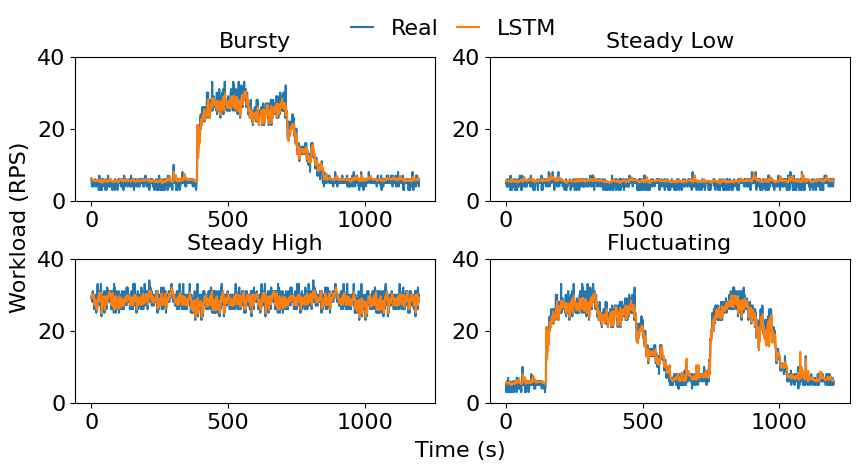

In [32]:
lstm = load_model(LSTM_PATH)
fig, axs = plt.subplots(2, 2, figsize=(10, 4.5))
for axes in axs:
    for ax in axes:
        ax.set_ylim([0, 40])


def get_x_y(data):
    x = []
    y = []
    input_length = 12
    data = data[:]
    for i in range(input_length):
        data.insert(0, data[0])
    for i in range(0, len(data) - input_length):
        x.extend(data[i : i + input_length])
        y.append(data[i + input_length])
    x = np.array(x)
    # print("shapes")
    # print(x.shape)
    # print(len(y))
    return tf.convert_to_tensor(x.reshape((-1, input_length, 1)), dtype=tf.float32), y


def get_arima_prediction(data):
    preds = []
    data = np.array(data).reshape((-1, 12))
    for history in data:
        model = ARIMA(history, order=(1, 0, 0))
        model_fit = model.fit()
        pred = int(max(model_fit.forecast(steps=2)))  # max
        preds.append(pred)
    return preds


damping_factor = 5
drawing_factor = 5 / 8

# bursty workload
start = 1296000
duration = 20 * 60  # 20 minutes
workload = twitter_workload_generator(f"{0}-{21*24*60*60}", damping_factor=5)
while True:
    selected_workload = workload[start : start + duration]
    if (
        max(selected_workload) - min(selected_workload) > 30
        and abs(selected_workload[0] - selected_workload[-200]) < 5
        and abs(selected_workload[0] - selected_workload[500]) > 30
    ):
        break
    start += 60 * 2


ax = axs[0][0]
rescaled_workload = (
    (np.array(selected_workload) * (drawing_factor)).astype(int).tolist()
)
ax.plot(list(range(len(selected_workload))), rescaled_workload, label="Real")
ax.set_title("Bursty")
x, _ = get_x_y(rescaled_workload)
ax.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
# arima = get_arima_prediction(x)
# ax.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
# print(f"start: {start}")  # 1301160
# print(f"end: {start+duration}")


start = 1296000
duration = 20 * 60  # 10 minutes
while True:
    selected_workload = workload[start : start + duration]
    if (
        max(selected_workload) - min(selected_workload) < 9
        and max(selected_workload) < 20
    ):
        break
    start += duration


ax2 = axs[0][1]
rescaled_workload = (
    (np.array(selected_workload) * (drawing_factor)).astype(int).tolist()
)
ax2.plot(list(range(len(selected_workload))), rescaled_workload, label="Real")
ax2.set_title("Steady Low")
x, _ = get_x_y(rescaled_workload)
ax2.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
# arima = get_arima_prediction(x)
# ax2.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
# print(f"start: {start}")  # 1299600
# print(f"end: {start+duration}")


start = 1296000
duration = 10 * 60  # 10 minutes
while True:
    selected_workload = workload[start : start + duration]
    if (
        max(selected_workload) - min(selected_workload) < 18
        and min(selected_workload) > 30
    ):
        break
    start += duration


ax3 = axs[1][0]
selected_workload = selected_workload * 2
rescaled_workload = (
    (np.array(selected_workload) * (drawing_factor)).astype(int).tolist()
)
ax3.plot(list(range(len(selected_workload))), rescaled_workload, label="Real")
ax3.set_title("Steady High")
x, _ = get_x_y(rescaled_workload)
ax3.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
# arima = get_arima_prediction(x)
# ax3.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)
# print(f"start: {start}")  # 1768800
# print(f"end: {start+duration}")


start = 1296000
duration = 10 * 60  # 10 minutes
while True:
    selected_workload = workload[start : start + duration]
    if max(selected_workload) - min(selected_workload) > 30:
        break
    start += duration

start2 = start + duration
while True:
    selected_workload2 = workload[start2 : start2 + duration]
    if max(selected_workload2) - min(selected_workload2) > 30:
        break
    start2 += duration
selected_workload = selected_workload + selected_workload2


ax4 = axs[1][1]
rescaled_workload = (
    (np.array(selected_workload) * (drawing_factor)).astype(int).tolist()
)
ax4.plot(list(range(len(selected_workload))), rescaled_workload, label="Real")
ax4.set_title("Fluctuating")
x, _ = get_x_y(rescaled_workload)
ax4.plot(list(range(len(selected_workload))), list(lstm.predict(x)), **lstm_plot_kwargs)
# arima = get_arima_prediction(x)
# ax4.plot(list(range(len(selected_workload))), arima, **arima_plot_kwargs)


plt.legend(
    fontsize=16,
    fancybox=False,
    ncol=3,
    frameon=False,
    bbox_to_anchor=(-0.1, 2.8),
    loc="upper center",
    handlelength=1,
    columnspacing=0.8,
)

# fig.tight_layout()
fig.text(0.51, -0.01, "Time (s)", ha="center", fontsize=16)
fig.text(0.06, 0.5, "Workload (RPS)", rotation=90, va="center", fontsize=16)
plt.subplots_adjust(wspace=0.15, hspace=0.4)
plt.savefig(
    os.path.join(FIGURES_PATH, "patterns.pdf"),
    dpi=600,
    format="pdf",
    bbox_inches="tight",
    pad_inches=0,
)

# print(f"start: {start} | start2: {start2}")  # start: 1301400 | start2: 1308600